# Presentación de resultados

En este cuaderno se aborda la presentación de resultados de cara al público. Se muestra las gráficas originales, como añadirles detalles geográficos (divisiones geográficas y Modelos de Elevación Digital). También se explora la división categórica y el resaltado de los datos.

**Nota:** A diferencia de los cuadernos anteriores, este no se implementa en funciones dentro del módulo `utilidades`. La razón es que cada gráfica tiene sus propios requisitos e implementarla sin una clase ya no es conveniente. Como cualquier gráfica tiene clases y subclases es mejor no realizar funciones envoltorio sobre estas pues resultan demasiado restrictivas. En su lugar se plantean procedimientos para llegar a ciertos resultados, que el lector tendrá que adaptar para sus requerimientos. Ello exige cierto conocimiento de las librerías más comunes como matplotlib de manera intensiva entre más especificos sean los requierimientos. Además no existe aquí un solo camino a tomar sino que estará ligado a sus conocimientos de la librería y de programación. 

Importamos las librerías como es usual.

In [29]:
import wradlib as wrl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import copy

import Bases_GUI as radar
import utilidades as util

Obviamente para graficar necesitamos los datos. 

In [3]:
file = 'C:/Python37/Lluvia/2019051415200000dBuZ.azi'
radardata = radar.read_data(file)
data = radardata.data['data']

Mostramos los datos

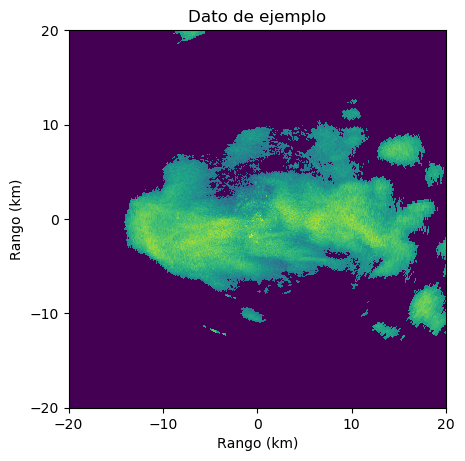

In [5]:
fig = util.ploteo(data, rmax=20, title='Dato de ejemplo')

Este corresponde a nuestro tan visto ejemplo de "Precipitación tipo 2"

Para que los datos finales sean realmente útiles en su representación deben estar ligados al sistema de proyección geográfico (por decir longitud/latitud). Para ello proyectaremos los datos usando el sistema WSG 84.

In [6]:
# Datos del radar necesarios(se pueden extraer de la metadata)
radar_location = (-80.638333,-5.170278,56) 
elevation = 2 

In [10]:
azi, r = util.ejes()
r = r * 1000    # Si no entiendes este paso ve el ejemplo de proyección
polargrid = np.meshgrid(r, azi)
coords, rad = wrl.georef.spherical_to_xyz(polargrid[0], polargrid[1], elevation, radar_location)
x = coords[..., 0]
y = coords[..., 1]

zone = wrl.georef.epsg_to_osr(4326)   # Número EPSG del sistema WSG 84
zone_coords = wrl.georef.reproject(coords, projection_source=rad, projection_target=zone)

x = zone_coords[..., 0]
y = zone_coords[..., 1]

xgrid = np.linspace(x.min(), x.max(), 1000)
ygrid = np.linspace(y.min(), y.max(), 1000)
grid_xy = np.meshgrid(xgrid, ygrid)
grid_xy = np.vstack((grid_xy[0].ravel(), grid_xy[1].ravel())).transpose()

xy=np.concatenate([x.ravel()[:,None],y.ravel()[:,None]], axis=1)
gridded = wrl.comp.togrid(src=xy, trg=grid_xy, radius=100., center=np.array([x.mean(), y.mean()]),
                          data=data.ravel(), interpol=wrl.ipol.Nearest)
# El método de interpolación es de prueba, si se cambia asegurese de modificar la máscara también. 
gridded = np.ma.masked_invalid(gridded).reshape((len(xgrid), len(ygrid)))

# Reenmascaramos los datos
gridded[gridded == -31.5] = np.NaN
gridded = np.ma.masked_invalid(gridded)

Graficamos los resultados. 

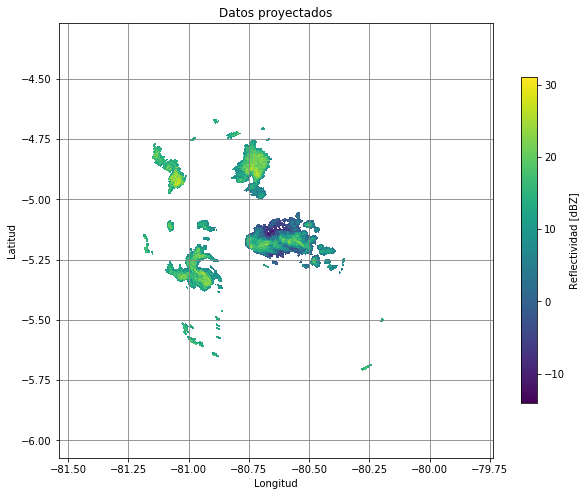

In [11]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, aspect="equal")
pm = ax.pcolormesh(xgrid, ygrid, gridded)
cbar = plt.colorbar(pm, shrink=0.75)
cbar.set_label('Reflectividad [dBZ]')
plt.title('Datos proyectados')
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.xlim(min(xgrid), max(xgrid))
plt.ylim(min(ygrid), max(ygrid))
plt.grid(color="grey")

Se puede observar como los datos se encuentran referenciados en latitud y longitud. Un siguiente paso es añadir un indicador en el punto donde está ubicado el radar.

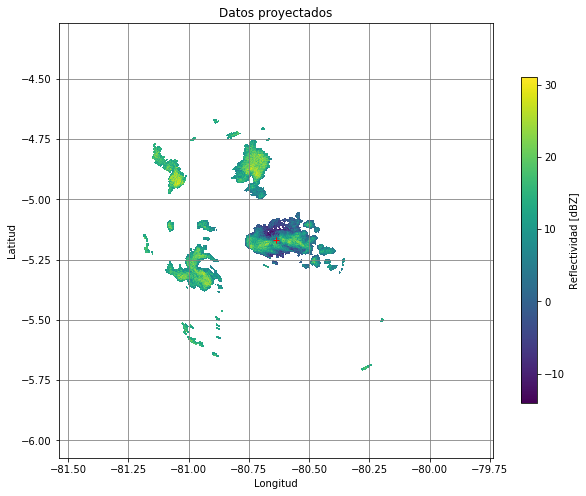

In [13]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, aspect="equal")
pm = ax.pcolormesh(xgrid, ygrid, gridded)
cbar = plt.colorbar(pm, shrink=0.75)
cbar.set_label('Reflectividad [dBZ]')
plt.title('Datos proyectados')
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.xlim(min(xgrid), max(xgrid))
plt.ylim(min(ygrid), max(ygrid))
plt.grid(color="grey")
# Indicador de posición del radar
plt.plot(radar_location[0], radar_location[1], 'r+', zorder=5) 

El siguiente paso es agregar los datos de las divisiones geográficas. Para ello necesitaremos un archivo Shapefile que contenga los multipolígonos que requerimos.

In [ ]:
def plot_borders(ax, file, rlimits=None, lw=2,*args,**kwargs):
    # Abrimos los datos del archivo y los filtramos espacialmente
    dataset, inLayer = wrl.io.open_vector(file)
    if rlimits != None : 
        lon_min = rlimits[0]
        lat_min = rlimits[1]
        lon_max = rlimits[2]
        lat_max = rlimits[3]
        inLayer.SetSpatialFilterRect(lon_min,lat_min,lon_max,lat_max)
    # Obtenemos los vectores a graficar 
    borders = wrl.georef.get_vector_coordinates(inLayer)
    wrl.vis.add_lines(ax, borders, color='black', lw = lw , zorder=4,*args, **kwargs)
    # Escalado
    ax.autoscale()
    return ax

Para agregar los datos necesitaremos usar los archivos shapefile.

In [15]:
file_per_adm0 = 'C:/Users/Elmer Lopez Ramirez/Downloads/PER_adm0.shp'
file_per_adm1 = 'C:/Users/Elmer Lopez Ramirez/Downloads/PER_adm1.shp'
file_per_adm2 = 'C:/Users/Elmer Lopez Ramirez/Downloads/PER_adm2.shp'
file_per_adm3 = 'C:/Users/Elmer Lopez Ramirez/Downloads/PER_adm3.shp'

In [16]:
# Límites impuestos al filtrado espacial rectangular
lon = np.array([-81.75,-79.5])
lat = np.array([-6.25,-4])
rlimits = (lon.min(),lat.min(),lon.max(),lat.max())

Ya con ellos estamos listos para agregarlos a nuestra figura.

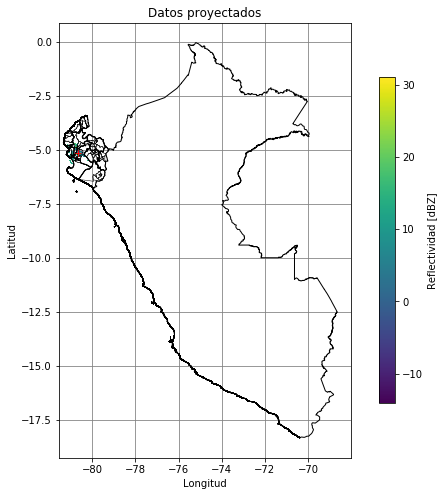

In [17]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, aspect="equal")
pm = ax.pcolormesh(xgrid, ygrid, gridded)
cbar = plt.colorbar(pm, shrink=0.75)
cbar.set_label('Reflectividad [dBZ]')
plt.title('Datos proyectados')
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.xlim(min(xgrid), max(xgrid))
plt.ylim(min(ygrid), max(ygrid))
plt.grid(color="grey")
plt.plot(radar_location[0], radar_location[1], 'r+', zorder=5) 
ax = plot_borders(ax=ax, file=file_per_adm0, rlimits=rlimits, lw=1)
ax = plot_borders(ax=ax, file=file_per_adm2, rlimits=rlimits, lw=1)
ax = plot_borders(ax=ax, file=file_per_adm3, rlimits=rlimits, lw=0.5)

Dado que no le hemos pasado los límites para mostrar en pantalla, sale todo el mapa. 

(-6.25, -4.0)

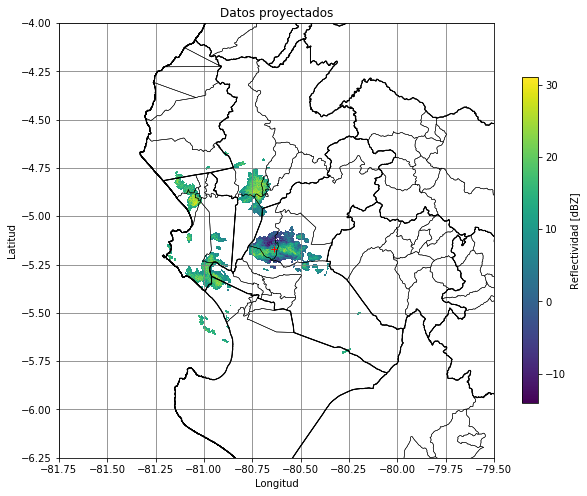

In [18]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, aspect="equal")
pm = ax.pcolormesh(xgrid, ygrid, gridded)
cbar = plt.colorbar(pm, shrink=0.75)
cbar.set_label('Reflectividad [dBZ]')
plt.title('Datos proyectados')
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.xlim(min(xgrid), max(xgrid))
plt.ylim(min(ygrid), max(ygrid))
plt.grid(color="grey")
plt.plot(radar_location[0], radar_location[1], 'r+', zorder=5) 
ax = plot_borders(ax=ax, file=file_per_adm0, rlimits=rlimits, lw=1)
ax = plot_borders(ax=ax, file=file_per_adm2, rlimits=rlimits, lw=1)
ax = plot_borders(ax=ax, file=file_per_adm3, rlimits=rlimits, lw=0.5)
# Pasamos los límites de la figura
plt.xlim(lon)
plt.ylim(lat)

**Nota:** Note que los bordes de las líneas se observan sobre los datos del radar.

(-6.25, -4.0)

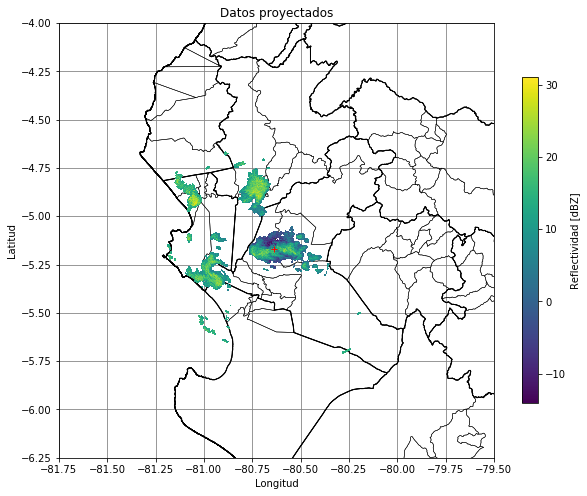

In [19]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, aspect="equal")
ax = plot_borders(ax=ax, file=file_per_adm0, rlimits=rlimits, lw=1)
ax = plot_borders(ax=ax, file=file_per_adm2, rlimits=rlimits, lw=1)
ax = plot_borders(ax=ax, file=file_per_adm3, rlimits=rlimits, lw=0.5)
pm = ax.pcolormesh(xgrid, ygrid, gridded, zorder = 5)
cbar = plt.colorbar(pm, shrink=0.75)
cbar.set_label('Reflectividad [dBZ]')
plt.title('Datos proyectados')
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.xlim(min(xgrid), max(xgrid))
plt.ylim(min(ygrid), max(ygrid))
plt.grid(color="grey")
plt.plot(radar_location[0], radar_location[1], 'r+', zorder=5) 
plt.xlim(lon)
plt.ylim(lat)

**Nota:** Note como al cambiar el **`zorder`** del Quadmesh este se dibuja por encima de las líneas de división política. Esto se debe a que dicho parámetro representa el orden de prioridad en las gráficas. Entre más alto sea su valor más al frente se ubica. 

La salida tiene un aspecto bastante bueno, pero se puede mejorar de acuerdo a lo que se quiera mostrar. Por ejemplo, el grosor de las líneas se puede configurar cambiando el parámetro **`lw`** de la función **`plot_borders`**. También es posible cambiar el color de las líneas a través de alguno de los argumentos enmascarados(args o kwargs). Sin embargo si se desea una configuración más avanzada(un color por cada provincia) se tienen que separar los multi-poligonos y aplicar las características que se desean. Como se ve, dar tanta flexibilidad al código no resulta ya tan sencillo. 

El siguiente paso que podemos hacer es añadir un modelo de elevación digital para el fondo. 

In [20]:
def plot_dem(ax, file, rlimits=None, *args, **kwargs):
    # Abrimos el archivo y definimos el espaciado en las unidades en las que se encuentre referenciado.
    # Esto será importante para el tiempo de carga que representa.
    ds = wrl.io.open_raster(file)
    ds = wrl.georef.reproject_raster_dataset(ds, spacing=0.005)
    rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(ds)
    # Filtrado espacial
    if rlimits != None :
        ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
        rastercoords = rastercoords[ind[1]:ind[3], ind[0]:ind[2], ...]
        rastervalues = rastervalues[ind[1]:ind[3], ind[0]:ind[2]]
    # Damos el color de fondo
    #ax.set_facecolor('b')
      
    # Usamos un colormap común para DEM (plt.cm.terrain) y una escala LogNorm
    dem = ax.pcolormesh(rastercoords[..., 0], rastercoords[..., 1], rastervalues, cmap=plt.cm.terrain, norm=LogNorm(),
                        vmin=1, vmax=4000, *args,**kwargs)
    
    return ax

Necesitamos añadir los archivos DEM correspondientes

In [21]:
file_RadarPiuraDEM = 'C:/Users/Elmer Lopez Ramirez/Downloads/RadarPiuraDEM.tif'
file_SRTM_PERU = 'C:/Users/Elmer Lopez Ramirez/Downloads/SRTM_PERU.tif'

Graficamos ahora incluyendo uno de los DEM.

(-6.25, -4.0)

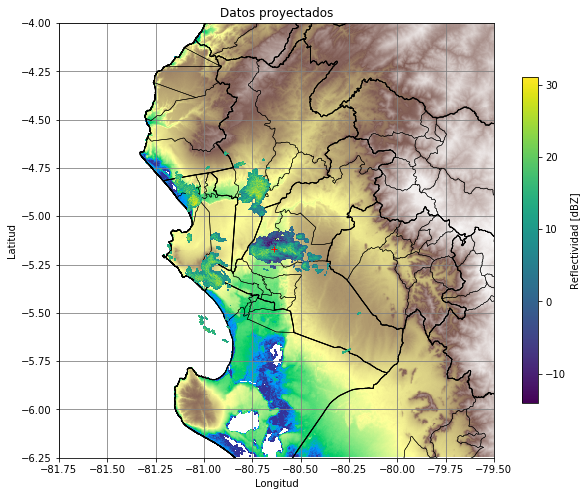

In [22]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, aspect="equal")
# Agregamos el DEM
ax = plot_dem(ax=ax, file=file_SRTM_PERU, rlimits=rlimits)
ax = plot_borders(ax=ax, file=file_per_adm0, rlimits=rlimits, lw=1)
ax = plot_borders(ax=ax, file=file_per_adm2, rlimits=rlimits, lw=1)
ax = plot_borders(ax=ax, file=file_per_adm3, rlimits=rlimits, lw=0.5)
pm = ax.pcolormesh(xgrid, ygrid, gridded, zorder = 5)
cbar = plt.colorbar(pm, shrink=0.75)
cbar.set_label('Reflectividad [dBZ]')
plt.title('Datos proyectados')
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.xlim(min(xgrid), max(xgrid))
plt.ylim(min(ygrid), max(ygrid))
plt.grid(color="grey")
plt.plot(radar_location[0], radar_location[1], 'r+', zorder=5) 
plt.xlim(lon)
plt.ylim(lat)

El resultado claramente es más atractivo, pero este DEM particular no colorea los valores del mar. ¿Cómo hacemos eso? La solución más simple es colocarlo como color de fondo en la figura. Note también que es más difícil identificar algunas nubes de tormenta. 

(-6.25, -4.0)

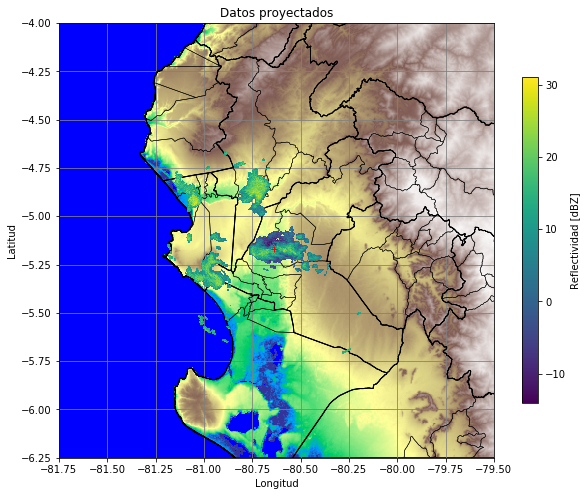

In [23]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, aspect="equal")
# Colocamos el color del fondo en azul
ax.set_facecolor('b')
ax = plot_dem(ax=ax, file=file_SRTM_PERU, rlimits=rlimits)
ax = plot_borders(ax=ax, file=file_per_adm0, rlimits=rlimits, lw=1)
ax = plot_borders(ax=ax, file=file_per_adm2, rlimits=rlimits, lw=1)
ax = plot_borders(ax=ax, file=file_per_adm3, rlimits=rlimits, lw=0.5)
pm = ax.pcolormesh(xgrid, ygrid, gridded, zorder = 5)
cbar = plt.colorbar(pm, shrink=0.75)
cbar.set_label('Reflectividad [dBZ]')
plt.title('Datos proyectados')
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.xlim(min(xgrid), max(xgrid))
plt.ylim(min(ygrid), max(ygrid))
plt.grid(color="grey")
plt.plot(radar_location[0], radar_location[1], 'r+', zorder=5) 
plt.xlim(lon)
plt.ylim(lat)

Vemos como el resultado es muy bonito(aunque no tanto como Camila). Pero aún así debemos considerar algunas cosas adicionales.
1. Debemos percatarnos que el color del DEM represente lo que en verdad queremos representar. Dichas consideraciones escapan de mi rango de acción, pero son perfectamente modificables cambiando el parámetro cmap y la configuración de la escala.
2. Lo mismo que sucede para el fondo, sucede para la escala que usamos para precipitación. Debemos usar una escala adecuada, que represente la naturaleza de los datos y sea intuitiva para el que verá los resultados. Y además esta debe ser fija y no relativa al máximo y mínimo de nuestros datos.
3. Se pueden agregar los nombres de provincias o distritos, pero debe cuidarse de sobrecargar la gráfica.
4. Puede ser de utilidad agregar el círculo de acción del radar. 
5. El resaltado de los datos para no camuflarlos con el fondo es igualmente importante. Para ello podemos reducir el factor alpha del DEM o se me ocurre, colocar los bordes de los núcleos de precipitación de un color que resalte.

Agregar el círculo es relativamente sencillo. Para ello necesitamos calcular su radio. 

In [24]:
radio = (xgrid.max() - xgrid.min()) / 2

Ya con el radio y las coordenadas del centro. podemos ubicar el círculo sin problemas

(-6.25, -4.0)

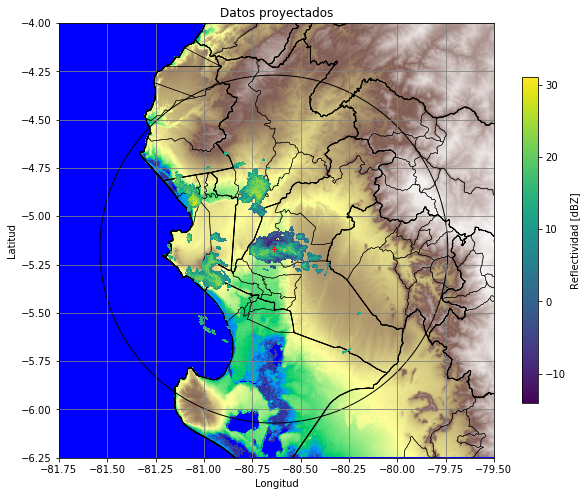

In [25]:
fig = plt.figure(figsize=(10,8))
# Creamos el círculo
circle = plt.Circle((radar_location[0], radar_location[1]), radio, color='k', fill=False) 
ax = plt.subplot(111, aspect="equal")
ax.set_facecolor('b')
ax = plot_dem(ax=ax, file=file_SRTM_PERU, rlimits=rlimits)
ax = plot_borders(ax=ax, file=file_per_adm0, rlimits=rlimits, lw=1)
ax = plot_borders(ax=ax, file=file_per_adm2, rlimits=rlimits, lw=1)
ax = plot_borders(ax=ax, file=file_per_adm3, rlimits=rlimits, lw=0.5)
pm = ax.pcolormesh(xgrid, ygrid, gridded, zorder = 5)
# Mostramos el círculo en pantalla
ax.add_artist(circle) 
cbar = plt.colorbar(pm, shrink=0.75)
cbar.set_label('Reflectividad [dBZ]')
plt.title('Datos proyectados')
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.xlim(min(xgrid), max(xgrid))
plt.ylim(min(ygrid), max(ygrid))
plt.grid(color="grey")
plt.plot(radar_location[0], radar_location[1], 'r+', zorder=5) 
plt.xlim(lon)
plt.ylim(lat)

Resaltar los datos será sin embargo un poco más complicado. Pero antes veamos como se vería si los datos se mostrasen en otras escalas. Para una discusión apropiada sobre el tema vea https://betterfigures.org/2015/06/23/picking-a-colour-scale-for-scientific-graphics/

Veamos los datos usando la escala PuBu

(-6.25, -4.0)

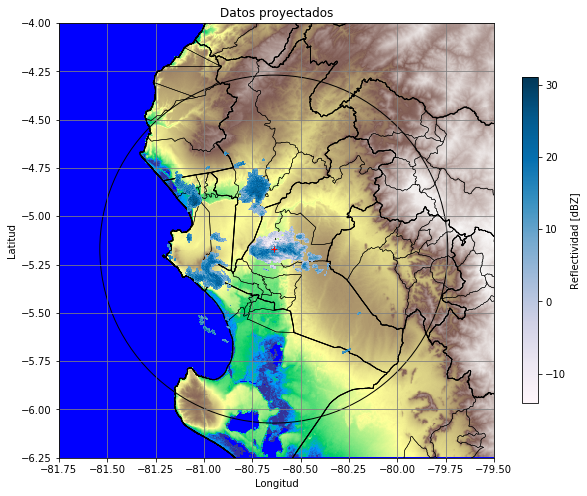

In [26]:
fig = plt.figure(figsize=(10,8))
circle = plt.Circle((radar_location[0], radar_location[1]), radio, color='k', fill=False) 
ax = plt.subplot(111, aspect="equal")
ax.set_facecolor('b')
ax = plot_dem(ax=ax, file=file_SRTM_PERU, rlimits=rlimits)
ax = plot_borders(ax=ax, file=file_per_adm0, rlimits=rlimits, lw=1)
ax = plot_borders(ax=ax, file=file_per_adm2, rlimits=rlimits, lw=1)
ax = plot_borders(ax=ax, file=file_per_adm3, rlimits=rlimits, lw=0.5)
# Note como asignamos el colormap
pm = ax.pcolormesh(xgrid, ygrid, gridded, zorder=5, cmap=plt.cm.PuBu)
ax.add_artist(circle) 
cbar = plt.colorbar(pm, shrink=0.75)
cbar.set_label('Reflectividad [dBZ]')
plt.title('Datos proyectados')
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.xlim(min(xgrid), max(xgrid))
plt.ylim(min(ygrid), max(ygrid))
plt.grid(color="grey")
plt.plot(radar_location[0], radar_location[1], 'r+', zorder=5) 
plt.xlim(lon)
plt.ylim(lat)

Ahora veremos el resultado usando la escala PuBuGn

(-6.25, -4.0)

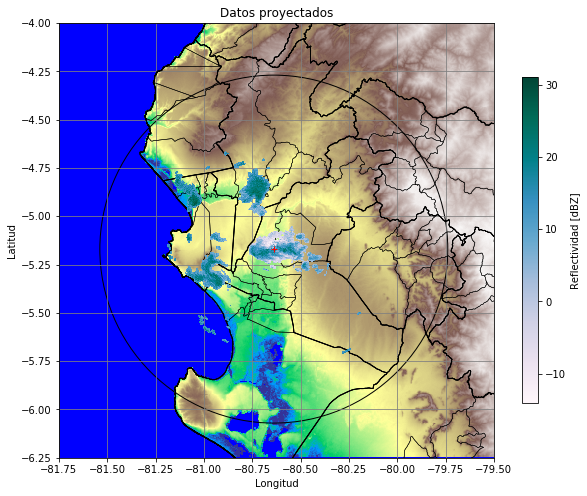

In [27]:
fig = plt.figure(figsize=(10,8))
circle = plt.Circle((radar_location[0], radar_location[1]), radio, color='k', fill=False) 
ax = plt.subplot(111, aspect="equal")
ax.set_facecolor('b')
ax = plot_dem(ax=ax, file=file_SRTM_PERU, rlimits=rlimits)
ax = plot_borders(ax=ax, file=file_per_adm0, rlimits=rlimits, lw=1)
ax = plot_borders(ax=ax, file=file_per_adm2, rlimits=rlimits, lw=1)
ax = plot_borders(ax=ax, file=file_per_adm3, rlimits=rlimits, lw=0.5)
# Note como asignamos el colormap
pm = ax.pcolormesh(xgrid, ygrid, gridded, zorder=5, cmap=plt.cm.PuBuGn)
ax.add_artist(circle) 
cbar = plt.colorbar(pm, shrink=0.75)
cbar.set_label('Reflectividad [dBZ]')
plt.title('Datos proyectados')
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.xlim(min(xgrid), max(xgrid))
plt.ylim(min(ygrid), max(ygrid))
plt.grid(color="grey")
plt.plot(radar_location[0], radar_location[1], 'r+', zorder=5) 
plt.xlim(lon)
plt.ylim(lat)

Ahora usando Blues

(-6.25, -4.0)

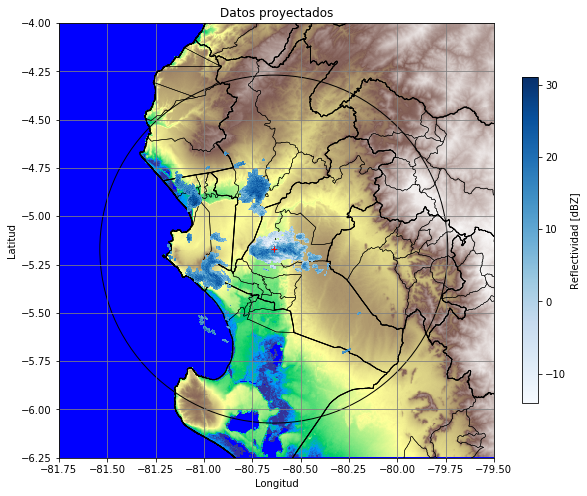

In [28]:
fig = plt.figure(figsize=(10,8))
circle = plt.Circle((radar_location[0], radar_location[1]), radio, color='k', fill=False) 
ax = plt.subplot(111, aspect="equal")
ax.set_facecolor('b')
ax = plot_dem(ax=ax, file=file_SRTM_PERU, rlimits=rlimits)
ax = plot_borders(ax=ax, file=file_per_adm0, rlimits=rlimits, lw=1)
ax = plot_borders(ax=ax, file=file_per_adm2, rlimits=rlimits, lw=1)
ax = plot_borders(ax=ax, file=file_per_adm3, rlimits=rlimits, lw=0.5)
# Note como asignamos el colormap
pm = ax.pcolormesh(xgrid, ygrid, gridded, zorder=5, cmap=plt.cm.Blues)
ax.add_artist(circle) 
cbar = plt.colorbar(pm, shrink=0.75)
cbar.set_label('Reflectividad [dBZ]')
plt.title('Datos proyectados')
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.xlim(min(xgrid), max(xgrid))
plt.ylim(min(ygrid), max(ygrid))
plt.grid(color="grey")
plt.plot(radar_location[0], radar_location[1], 'r+', zorder=5) 
plt.xlim(lon)
plt.ylim(lat)

Es posible remarcar los datos usando un borde, pero eso se explorará en otra ocasión. Además a estas alturas, ya debería ser evidente.